In [ ]:

%pip install implicit scikit-learn pandas numpy

   ---------------------------------------- 0.0/748.6 kB ? eta -:--:--
   -------------- ------------------------- 262.1/748.6 kB ? eta -:--:--
   ---------------------------------------- 748.6/748.6 kB 2.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_and_preprocess_data(user_interactions_path, meta_data_path):
    interactions_df = pd.read_csv(user_interactions_path)
    meta_df = pd.read_csv(meta_data_path)
    
    # Convert timestamps
    interactions_df['updated_at'] = pd.to_datetime(interactions_df['updated_at'])
    meta_df['updated_at'] = pd.to_datetime(meta_df['updated_at'])
    meta_df['published_at'] = pd.to_datetime(meta_df['published_at'])
    
    interactions_df = interactions_df.sort_values('updated_at')
    
    return interactions_df, meta_df

interactions_df, meta_df = load_and_preprocess_data('user_interaction.csv', 'metadata.csv')


In [5]:

print("User Interactions:")
print(interactions_df.head())
print("\nMeta Data:")
print(meta_df.head())

User Interactions:
                  user_id      pratilipi_id  read_percent  \
1033131  5506791954036110  1377786225804654         100.0   
1415300  5506791980439899  1377786228150074         100.0   
2318259  5506791979182708  1377786218415632         100.0   
952322   5506791996330389  1377786219497547         100.0   
2114134  5506791961370166  1377786224952303         100.0   

                     updated_at  
1033131 2022-03-18 15:14:41.827  
1415300 2022-03-18 15:14:42.120  
2318259 2022-03-18 15:14:42.134  
952322  2022-03-18 15:14:42.170  
2114134 2022-03-18 15:14:42.282  

Meta Data:
          author_id      pratilipi_id category_name  reading_time  \
0 -3418949279741297  1025741862639304   translation             0   
1 -2270332351871840  1377786215601277   translation           171   
2 -2270332352037261  1377786215601962   translation            92   
3 -2270332352521845  1377786215640994   translation             0   
4 -2270332349665658  1377786215931338   translation  

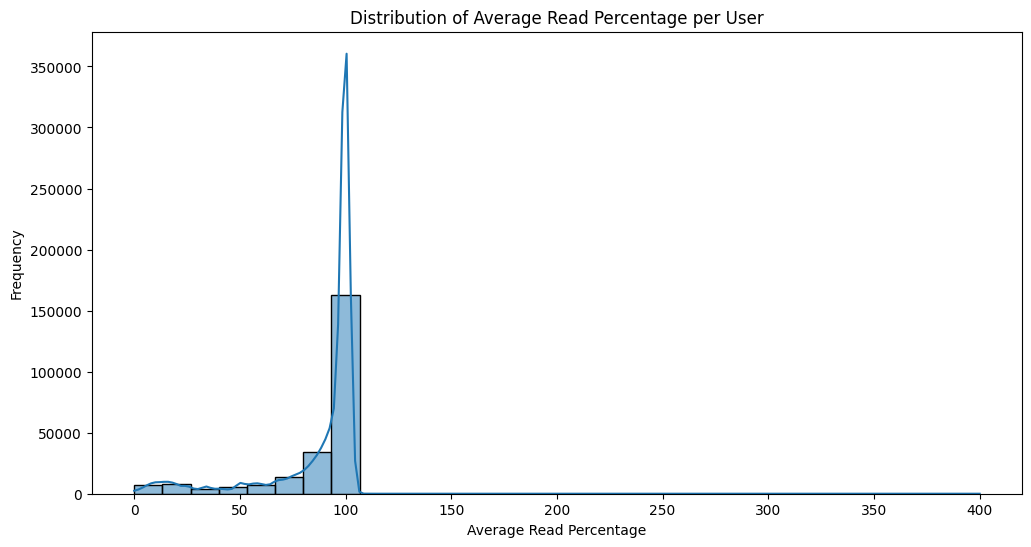

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load user interaction data
user_interactions = interactions_df

# Convert timestamp
user_interactions['updated_at'] = pd.to_datetime(
    user_interactions['updated_at'])

# Aggregate reading behavior
user_reading_stats = user_interactions.groupby('user_id').agg({
    'read_percent': ['mean', 'median', 'count']
}).reset_index()

user_reading_stats.columns = [
    'user_id', 'avg_read_percentage', 'median_read_percentage', 'total_reads']

# Plot reading behavior distribution
plt.figure(figsize=(12, 6))
sns.histplot(user_reading_stats['avg_read_percentage'], bins=30, kde=True)
plt.title('Distribution of Average Read Percentage per User')
plt.xlabel('Average Read Percentage')
plt.ylabel('Frequency')
plt.show()

In [14]:
print("Checking data structure:")
print("\nColumns:", interactions_df.columns.tolist())
print("\nSample of data:")
print(interactions_df.head())
print("\nData info:")
print(interactions_df.info())

Checking data structure:

Columns: ['user_id', 'pratilipi_id', 'read_percent', 'updated_at']

Sample of data:
                  user_id      pratilipi_id  read_percent  \
1033131  5506791954036110  1377786225804654         100.0   
1415300  5506791980439899  1377786228150074         100.0   
2318259  5506791979182708  1377786218415632         100.0   
952322   5506791996330389  1377786219497547         100.0   
2114134  5506791961370166  1377786224952303         100.0   

                     updated_at  
1033131 2022-03-18 15:14:41.827  
1415300 2022-03-18 15:14:42.120  
2318259 2022-03-18 15:14:42.134  
952322  2022-03-18 15:14:42.170  
2114134 2022-03-18 15:14:42.282  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 2500000 entries, 1033131 to 2186369
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       int64         
 1   pratilipi_id  int64         
 2   read_percent  float64       
 3   updated_at    datet

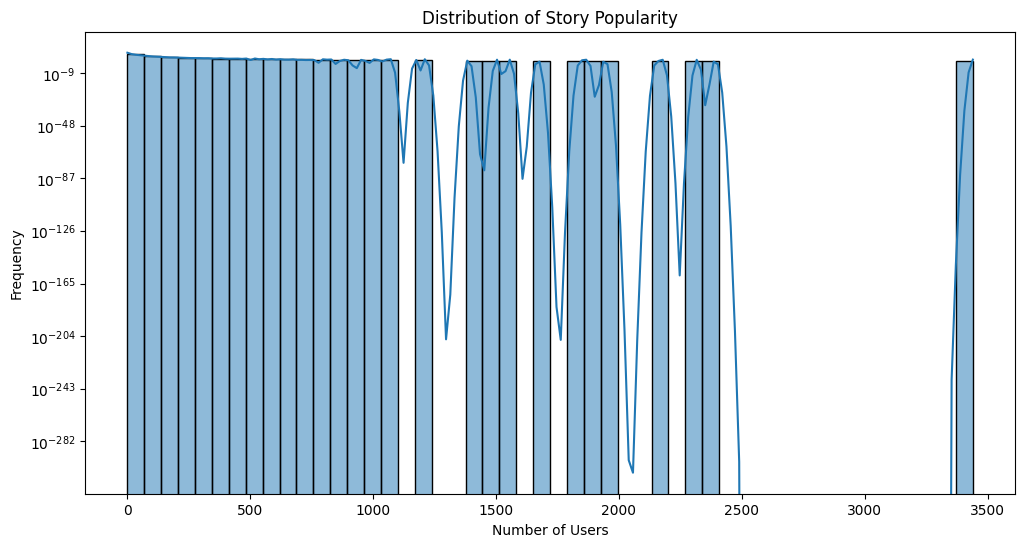

In [15]:
story_popularity = user_interactions.groupby('pratilipi_id').agg({
    'user_id': 'count',
    'read_percent': 'mean'
}).reset_index()

story_popularity.columns = ['pratilipi_id', 'num_users', 'avg_read_percentage']

# Plot story popularity distribution
plt.figure(figsize=(12, 6))
sns.histplot(story_popularity['num_users'], bins=50, kde=True)
plt.title('Distribution of Story Popularity')
plt.xlabel('Number of Users')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

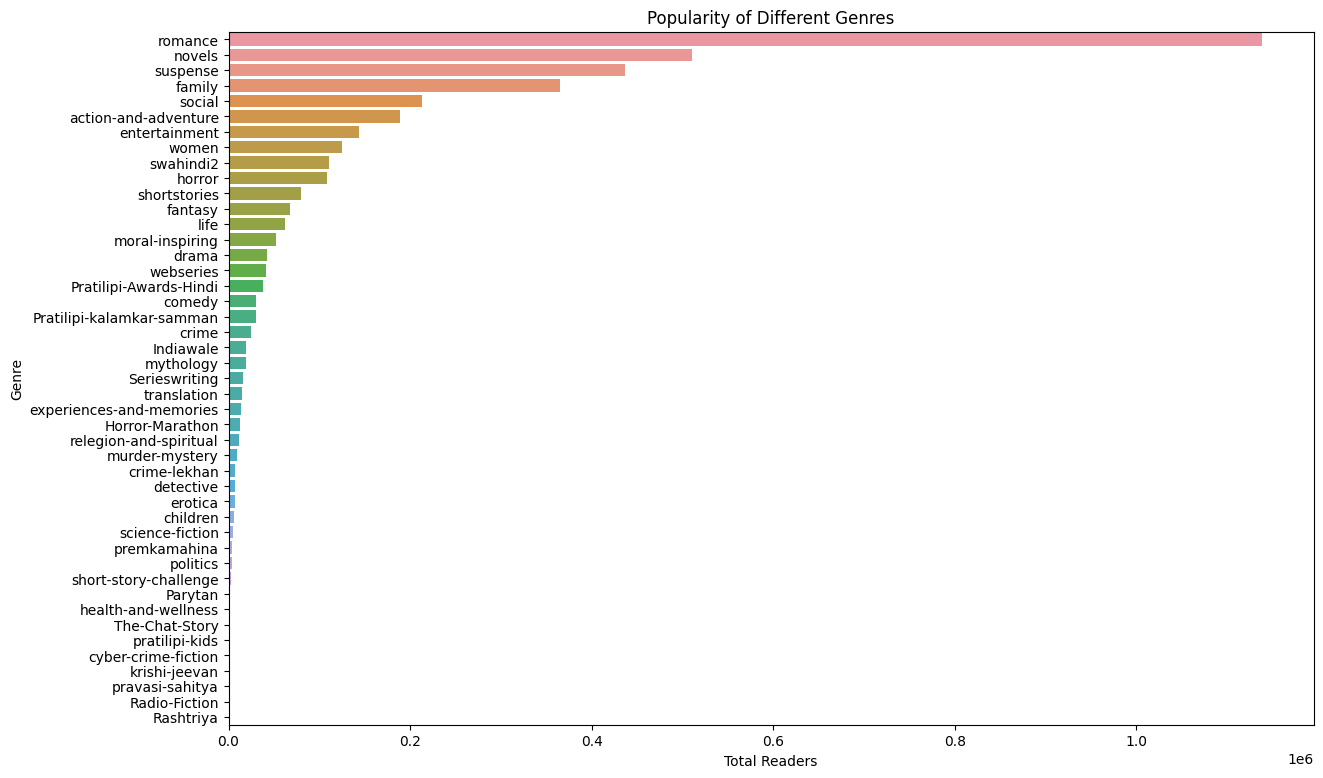

In [16]:
data_metadata = meta_df

# Merge with story popularity data
genre_popularity = story_popularity.merge(
    data_metadata[['pratilipi_id', 'category_name']], on='pratilipi_id', how='left')

# Aggregate genre-based popularity
genre_stats = genre_popularity.groupby('category_name').agg({
    'num_users': 'sum',
    'avg_read_percentage': 'mean'
}).reset_index()

# Plot genre popularity
plt.figure(figsize=(14, 9))
sns.barplot(data=genre_stats.sort_values(by='num_users',
            ascending=False), x='num_users', y='category_name')
plt.title('Popularity of Different Genres')
plt.xlabel('Total Readers')
plt.ylabel('Genre')
plt.show()

In [17]:
from scipy.sparse import csr_matrix

user_mapping = {id: i for i, id in enumerate(
    interactions_df['user_id'].unique())}
item_mapping = {id: i for i, id in enumerate(
    interactions_df['pratilipi_id'].unique())}

# 2. Create the necessary variables for sparse matrix
user_indices = [user_mapping[user] for user in interactions_df['user_id']]
item_indices = [item_mapping[item] for item in interactions_df['pratilipi_id']]
# Using read_percent as ratings
ratings = interactions_df['read_percent'].values

# 3. Get dimensions for the matrix
n_users = len(user_mapping)
n_items = len(item_mapping)

# 4. Now create the sparse matrix
sparse_matrix = csr_matrix((ratings, (user_indices, item_indices)),
                           shape=(n_users, n_items),
                           dtype=np.float32)

In [15]:
from sklearn.model_selection import train_test_split


def split_train_test(sparse_matrix, test_size=0.25, random_state=42):
    """
    Split the sparse interaction matrix into training and test sets
    
    Parameters:
    -----------
    sparse_matrix : scipy.sparse.csr_matrix
        The user-item interaction matrix
    test_size : float
        Proportion of data to use for testing (default: 0.25 as per README)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    train_matrix : scipy.sparse.csr_matrix
        Training set matrix
    test_matrix : scipy.sparse.csr_matrix
        Test set matrix
    """

    # Get indices of all non-zero elements
    nonzero = sparse_matrix.nonzero()
    indices = list(zip(nonzero[0], nonzero[1]))
    values = sparse_matrix.data

    # Split the indices
    train_indices, test_indices = train_test_split(
        range(len(indices)),
        test_size=test_size,
        random_state=random_state
    )

    # Create training matrix
    train_matrix = sparse_matrix.copy()
    train_matrix.data = np.zeros_like(train_matrix.data)
    for idx in train_indices:
        row, col = indices[idx]
        train_matrix[row, col] = values[idx]

    # Create test matrix
    test_matrix = sparse_matrix.copy()
    test_matrix.data = np.zeros_like(test_matrix.data)
    for idx in test_indices:
        row, col = indices[idx]
        test_matrix[row, col] = values[idx]

    # Convert to CSR format for efficiency
    train_matrix = train_matrix.tocsr()
    test_matrix = test_matrix.tocsr()

    return train_matrix, test_matrix

train_matrix, test_matrix = split_train_test(sparse_matrix)

In [16]:
# Print statistics about the split
print(
    f"Original matrix density: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.6f}")
print(
    f"Training matrix density: {train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]):.6f}")
print(
    f"Test matrix density: {test_matrix.nnz / (test_matrix.shape[0] * test_matrix.shape[1]):.6f}")

Original matrix density: 0.000043
Training matrix density: 0.000043
Test matrix density: 0.000043


In [17]:
class PratilipiDataset(Dataset):
    def __init__(self, user_indices, item_indices, ratings):
        self.user_indices = torch.LongTensor(user_indices)
        self.item_indices = torch.LongTensor(item_indices)
        # Normalize ratings to 0-1 range
        self.ratings = torch.FloatTensor(
            ratings) / 100.0  # Since read_percent is 0-100

    def __len__(self):
        return len(self.ratings)  # Return the number of samples in the dataset

    def __getitem__(self, idx):
        return (self.user_indices[idx], self.item_indices[idx], self.ratings[idx])

In [18]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(NCF, self).__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        self.fc_layers = nn.Sequential(
            nn.Linear(2 * embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

In [19]:
def forward(self, user_input, item_input):
    # Get embeddings
    user_embedded = self.user_embedding(user_input)
    item_embedded = self.item_embedding(item_input)

    # Concatenate embeddings
    vector = torch.cat([user_embedded, item_embedded], dim=-1)

    # Pass through MLP
    prediction = self.fc_layers(vector)
    return prediction.squeeze()

In [20]:
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            predictions = model(users, items)
            loss = criterion(predictions, ratings)
            total_loss += loss.item()

    return total_loss / len(test_loader)

In [21]:
# Split data into train and validation
train_size = int(0.8 * len(user_indices))
train_dataset = PratilipiDataset(
    user_indices[:train_size],
    item_indices[:train_size],
    ratings[:train_size]
)
val_dataset = PratilipiDataset(
    user_indices[train_size:],
    item_indices[train_size:],
    ratings[train_size:]
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [22]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (users, items, ratings) in enumerate(train_loader):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            predictions = model(users, items)
            loss = criterion(predictions, ratings)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 100 == 0:
                print(
                    f'Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}')

        # Validation
        val_loss = evaluate_model(model, val_loader, device)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

In [23]:
def prepare_and_train():
    num_users = len(user_mapping)
    num_items = len(item_mapping)

    # Create train/val datasets
    train_dataset = PratilipiDataset(
        user_indices[:train_size],
        item_indices[:train_size],
        ratings[:train_size]
    )
    val_dataset = PratilipiDataset(
        user_indices[train_size:],
        item_indices[train_size:],
        ratings[train_size:]
    )

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)

    model = NCF(num_users, num_items)
    NCF.forward = forward

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, train_loader, val_loader, device=device)

    return model


model = prepare_and_train()

Epoch 1/10 - Batch 0/7813 - Loss: 0.2560
Epoch 1/10 - Batch 100/7813 - Loss: 0.0630
Epoch 1/10 - Batch 200/7813 - Loss: 0.0629
Epoch 1/10 - Batch 300/7813 - Loss: 0.0531
Epoch 1/10 - Batch 400/7813 - Loss: 0.0446
Epoch 1/10 - Batch 500/7813 - Loss: 0.0325
Epoch 1/10 - Batch 600/7813 - Loss: 0.0500
Epoch 1/10 - Batch 700/7813 - Loss: 0.0571
Epoch 1/10 - Batch 800/7813 - Loss: 0.0641
Epoch 1/10 - Batch 900/7813 - Loss: 0.0585
Epoch 1/10 - Batch 1000/7813 - Loss: 0.0385
Epoch 1/10 - Batch 1100/7813 - Loss: 0.0429
Epoch 1/10 - Batch 1200/7813 - Loss: 0.0395
Epoch 1/10 - Batch 1300/7813 - Loss: 0.0581
Epoch 1/10 - Batch 1400/7813 - Loss: 0.0302
Epoch 1/10 - Batch 1500/7813 - Loss: 0.0482
Epoch 1/10 - Batch 1600/7813 - Loss: 0.0507
Epoch 1/10 - Batch 1700/7813 - Loss: 0.0611
Epoch 1/10 - Batch 1800/7813 - Loss: 0.0393
Epoch 1/10 - Batch 1900/7813 - Loss: 0.0365
Epoch 1/10 - Batch 2000/7813 - Loss: 0.0483
Epoch 1/10 - Batch 2100/7813 - Loss: 0.0557
Epoch 1/10 - Batch 2200/7813 - Loss: 0.0281


In [24]:
def test_model(model, user_id, num_recommendations=5):
    model.eval()  # Set model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        # Get user index from mapping
        user_idx = user_mapping[user_id]
        user_tensor = torch.LongTensor([user_idx]).to(device)

        # Create tensors for all items
        all_items = torch.LongTensor(list(item_mapping.values())).to(device)

        # Expand user tensor to match items dimension
        user_tensor = user_tensor.expand(len(all_items))

        # Get predictions for all items
        predictions = model(user_tensor, all_items)

        # Get top N recommendations
        top_n = torch.topk(predictions, num_recommendations)

        # Convert indices back to pratilipi_ids
        reverse_item_mapping = {v: k for k, v in item_mapping.items()}
        recommended_items = [reverse_item_mapping[idx.item()]
                             for idx in top_n.indices]

        return recommended_items

In [25]:
def generate_recommendations():
    # Load the best saved model
    model = NCF(num_users=len(user_mapping), num_items=len(item_mapping))
    model.load_state_dict(torch.load('best_model.pt'))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Test for a specific user
    test_user_id = list(user_mapping.keys())[0]  # Get first user as example
    recommendations = test_model(model, test_user_id)

    print(f"Recommendations for user {test_user_id}:")
    for i, item_id in enumerate(recommendations, 1):
        print(f"{i}. Pratilipi ID: {item_id}")

    return recommendations

In [26]:
# Calculate evaluation metrics
def calculate_metrics(model, test_loader, device):
    model.eval()
    total_loss = 0
    predictions_list = []
    actuals_list = []

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            predictions = model(users, items)

            predictions_list.extend(predictions.cpu().numpy())
            actuals_list.extend(ratings.cpu().numpy())

    # Calculate MSE
    mse = np.mean((np.array(predictions_list) - np.array(actuals_list)) ** 2)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAE
    mae = np.mean(np.abs(np.array(predictions_list) - np.array(actuals_list)))

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

In [27]:
def test_and_evaluate():
    # Load model
    model = NCF(num_users=len(user_mapping), num_items=len(item_mapping))
    model.load_state_dict(torch.load('best_model.pt'))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Generate recommendations
    recommendations = generate_recommendations()

    # Create test dataset and loader
    test_dataset = PratilipiDataset(
        user_indices[train_size:],
        item_indices[train_size:],
        ratings[train_size:]
    )
    test_loader = DataLoader(test_dataset, batch_size=256)

    # Calculate metrics
    metrics = calculate_metrics(model, test_loader, device)

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return recommendations, metrics

In [28]:
recommendations, metrics = test_and_evaluate()

Recommendations for user 5506791954036110:
1. Pratilipi ID: 1377786228274181
2. Pratilipi ID: 1377786228254759
3. Pratilipi ID: 1377786228240538
4. Pratilipi ID: 1377786228333808
5. Pratilipi ID: 1377786228214640

Model Performance Metrics:
MSE: 0.0465
RMSE: 0.2156
MAE: 0.1136


In [29]:
def save_model_files(model, user_mapping, item_mapping):
    # Save model
    torch.save(model.state_dict(), 'best_model.pt')

    # Save mappings
    torch.save(user_mapping, 'user_mapping.pt')
    torch.save(item_mapping, 'item_mapping.pt')

    print("Model and mappings saved successfully!")


# Call this after training
save_model_files(model, user_mapping, item_mapping)

Model and mappings saved successfully!
